[pilab](https://github.com/jooh/pilab) is a Matlab package that contains my standard tools for data analysis of functional MRI, behavioural and eye tracking data.

This post is the first of a series of tutorials where we run pilab analyses on simulated data. Today we will cover a basic single subject fMRI analysis, including cross-validated prediction of time series. You will need my Matlab [figure code](https://github.com/jooh/matlab-plotting) and probably my [general-purpose utility code](https://github.com/jooh/johansmatlab) to get the example below to run. Have fun!

### Building simulated fMRI data
Let's first make up some data to model. Notice that we assign each condition a true parameter *b*, which is a weight for each condition on each voxel.

In [56]:
% control variables for the simulation
% number of volumes (TRs)
n = 200;
% frame period - one volume every tr s
tr = 2;
% number of onsets to include in each run
ntrial = 20;
ncon = 4;
nvox = 50;
nrun = 2;
% true parameters - same across runs. +1 to model variations in constant
b = rand(ncon+1,nvox);

For each run of the experiment, we make up a set of *onsets* (uniformly distributed over the run), and assign
each onset to a *conind* (effectively the column index in the final design matrix). We then convolve the onsets
with a hemodynamic response function to construct the run-specific design matrix *X*.

The signal in this run is simply the design matrix weighted by the true parameters, *X*\**b*. To this we add a touch of noise to construct the final data.

Finally, we plug the convolved design matrix and data into Volume instances. These are container classes that make is easy to index in the sample dimension (e.g. runs) or feature dimension (e.g., regions of interest) while keeping any meta data in register.

In [45]:
designvol = cell(nrun,1);
datavol = cell(nrun,1);
for r = 1:nrun
    % different trial order in each run
    conind = ceil(rand(ntrial,1) * ncon);
    onsets = rand(ntrial,1) * n;
    X = [convolveonsets(onsets,conind,tr,n,'dur',1) ones(n,1)];
    % scale design matrix to peak at 1
    X = X / max(X(:));
    % construct data as some mixture of gaussian noise and the true parameters
    % scaled by each predictor
    data = randn(n,nvox)*.2 + X*b;
    % build Volume instances for convolved design and data
    metasamp = struct('chunks',ones(n,1)*r);
    designvol{r} = Volume(X,'frameperiod',tr,'metasamples',metasamp,...
        'metafeatures',struct('labels',{{'a','b','c','d','constant'}}));
    datavol{r} = Volume(data,'frameperiod',tr,'metasamples',metasamp);
end
% operator overloading means we can use standard concatenation syntax to combine
% the Volume instances over runs
datavol = cat(1,datavol{:});
designvol = cat(1,designvol{:});
datavol

datavol = 
  Volume with properties:

              data: [400x50 double]
          nsamples: 400
         nfeatures: 50
              meta: [1x1 struct]
              desc: [1x1 struct]
    standardstruct: [1x1 struct]
       frameperiod: 2


Let's see what we have so far. Notice how the meta data is used to provide labels for the legend, and the
frameperiod to express the X axis in seconds.

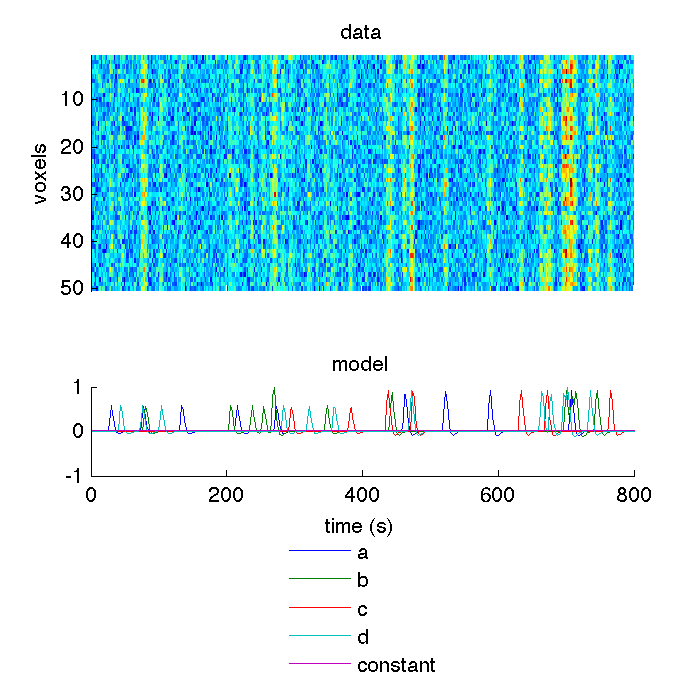

In [55]:
%plot -s 700,700 -r 300 -f svg
ax = subplot(2,1,1);
imagesc(datavol.data');
title('data');
ylabel('voxels');
% hide the x axis. Don't you wish Matlab provided a more elegant way of doing this?
set(gca,'xcolor',[1 1 1]);
ax(2) = subplot(2,1,2);
% plot the data in second units by scaling frameperiod
ph = plot((1:designvol.nsamples)*designvol.frameperiod,designvol.data);
xlabel('time (s)');
title('model');
lh = legend(ph,designvol.meta.features.labels,'location','southoutside');
set([lh ax],'box','off');

### Time course fit and out of sample prediction
The basic design logic of pilab is to have independent classes for storing and analysing data. So now we convert
the Volume to a GLM instance. Other converters are available for data that doesn't come from a volume
(see spm2glm, array2glm).

Before we do the conversion, we project out the constant from data and design matrix. This is equivalent to a mean
subtraction. It's often convenient to remove the constant (and higher degree polynomials) before cross-validating to
ensure that performance is not dominated by trends in the data.

In [57]:
[filtereddatavol,filtereddesignvol] = preprocessvols(datavol,designvol,...
    'covariatedeg','','ignorelabels','constant');
model = vol2glm(filtereddesignvol,filtereddatavol);
% notice that the model only contains 4 regressors as the constant has been projected out
model(1)

(preprocessvols) projecting out 1 covariates
ans = 
  GLM with properties:

              X: [200x4 double]
           data: [200x50 double]
       nsamples: 200
      nfeatures: 50
    npredictors: 4
        cvgroup: []
      nrandsamp: 200


Let's see how well the parameter estimates from run 1 can predict the time courses from run 2. We calculate R2 - the
[coefficient of determination](https://en.wikipedia.org/wiki/Coefficient_of_determination). Which incidentally is *not* the same as the squared correlation when tested on independent data - this is why a few r2 estimates below are negative. We plot the first voxel to illustrate. 

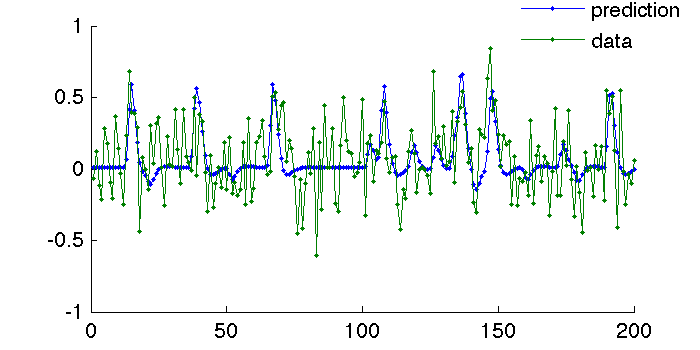

r2 =
  Columns 1 through 7
    0.2147    0.3774    0.4088    0.3922    0.1148    0.3768    0.3641
  Columns 8 through 14
    0.0137    0.4517    0.2212    0.0732    0.0243    0.2135    0.3146
  Columns 15 through 21
    0.1862    0.3708    0.2332    0.3396    0.1562    0.0597    0.0420
  Columns 22 through 28
    0.3612   -0.0075    0.3505    0.3530    0.1016    0.4105    0.3929
  Columns 29 through 35
    0.3415    0.4135    0.1783    0.4411    0.2167    0.0911    0.1315
  Columns 36 through 42
    0.3588    0.4014    0.2200    0.3344    0.2518    0.2715    0.3487
  Columns 43 through 49
    0.3643    0.0271    0.1844    0.3629    0.2619    0.0874    0.3359
  Column 50
    0.1556


In [58]:
%plot -s 700,350 -r 300 -f svg
% cross-validated prediction - use model(2) fit and model(1) design matrix
% Notice that the GLM is an object array class, so can be indexed like a struct
% to run particular methods on say a train and a test split of the data.
prediction = predictY(model(2),model(1).X);
% evaluate on model(1) data
r2 = rsquare(model(1),prediction)
% visualise fit
ph = plot([prediction(:,1) model(1).data(:,1)],'.-');
lh = legend(ph,{'prediction','data'},'location','best');
set([gca,lh],'box','off');

That's it for today. Next time we will look at how to calculate linear discriminant contrasts - a pseudo-distance metric that is often used for representational similarity analysis.